### Импорт необходимых библиотек

In [361]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')

In [362]:
# фиксируйте RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

### Загрузка данных

In [363]:
# подгрузим данные из соревнования
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR + '\hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR + '\hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR + '\submission.csv') # самбмишн

**Расшифровка обозначения признаков**

    hotel_address — адрес отеля;
    review_date — дата, когда рецензент разместил соответствующий отзыв;
    average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
    hotel_name — название отеля;
    reviewer_nationality — страна рецензента;
    negative_review — отрицательный отзыв, который рецензент дал отелю;
    review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
    positive_review — положительный отзыв, который рецензент дал отелю;
    review_total_positive_word_counts — общее количество слов в положительном отзыве.
    reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
    total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
    total_number_of_reviews — общее количество действительных отзывов об отеле;
    tags — теги, которые рецензент дал отелю;
    days_since_review — количество дней между датой проверки и датой очистки;
    additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
    lat — географическая широта отеля;
    lng — географическая долгота отеля.



In [364]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], ignore_index=True) # объединяем

### Удаление дублей

In [365]:
# проведём очистку df_train от дублей
print(f'Количестов записей в исходном датасете df_train: {df_train.shape[0]}')
# формируем список наименований признаков
df_train_columns = list(df_train.columns)
# удаляем дубли
df_train = df_train.drop_duplicates(subset=df_train_columns)
print(f'Результирующее число записей после удаления дублей в df_train: {df_train.shape[0]}')

Количестов записей в исходном датасете df_train: 386803
Результирующее число записей после удаления дублей в df_train: 386496


### Исследование данных, поиск аномалий

#### Адрес и название отелей

Проверим, совпадает ли количество названий отелей с их адресами

In [366]:
print('Количество уникальных наименований отелей:', data['hotel_name'].unique().shape[0])
print('Количество уникальных адресов отелей:', data['hotel_address'].unique().shape[0])

Количество уникальных наименований отелей: 1492
Количество уникальных адресов отелей: 1493


Адресов больше, чем названий. Попробуем выяснить, где есть несоответствия.

In [367]:
# сгруппируем уникальные адреса отелей по названиям
grouped_address_name = data.groupby('hotel_name')['hotel_address'].unique()
# найдем отели, у которых более одного адреса
for hotel in grouped_address_name.index:
    if len(grouped_address_name[hotel]) > 1:
        print('Название отеля:', hotel)
        print('Адреса отеля:', grouped_address_name[hotel])

Название отеля: Hotel Regina
Адреса отеля: ['Bergara 2 4 Eixample 08002 Barcelona Spain'
 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'
 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


In [368]:
# сгруппируем уникальные названия по адресам
grouped_name_address = data.groupby('hotel_address')['hotel_name'].unique()
# найдем отели, находящиеся по одному адресу
for address in grouped_name_address.index:
    if len(grouped_name_address[address]) > 1:
        print('Адрес:', address)
        print('Названия отелей:', grouped_name_address[address])

Адрес: 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
Названия отелей: ['Club Quarters Hotel Trafalgar Square' 'The Grand at Trafalgar Square']


Интересные наблюдения, есть и неуникальное название отеля, и несколько отелей на одном адресе. Но для нашей задачи эти находки не очень полезные. Название отеля и полный адрес далее будут преобразовываться в другие признаки.

#### Исследование даты создания отзыва

Проверим даты размещения отзыва (review_date), посмотрим, как количество оставляемых отзывов распределено по датам.

In [369]:
# преобразуем признак с датой в datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [370]:
# посмотрим на начало и конец периода наблюдений
print(data['review_date'].min())
print(data['review_date'].max())

2015-08-04 00:00:00
2017-08-03 00:00:00


In [371]:
# для проверки распределения количества отзывов по дням сгруппируем данные и построим линейный график
grouped_date_review = data.groupby(by=['review_date'], as_index=True)['review_date'].count()
lineplot = px.line(grouped_date_review, title='Распределение количества оставляемых отзывов по датам')
lineplot.show()

График показывает, что количество отзывов зависит от дня недели, прослеживается закономерность. При этом  почти не видно сезонных всплесков, количество отзывов практически не зависит от времени года. На графике присуствуют всплески, которые пока сложно объяснить. В датасет точно стоит добавить признак дня недели. Возможно признак месяца или номера недели повлияет на модель. Сделаем это на этапе формирования новых признаков.

In [372]:
# для проверки распределения количества отзывов по дням сгруппируем данные и построим линейный график
grouped_date_review = df_train.groupby(by=['review_date'], as_index=True)['reviewer_score'].median()
lineplot = px.line(grouped_date_review, title='Распределение медианной оценки по датам')
lineplot.show()

Наблюдается некая сезонность, этот признак можно использовать для выделения сезона.

#### Распределение оценок

Теперь посмотрим на распределение оценок. Построим коробчатую диаграмму для признаков (reviewer score и average score).

Так как оценка рецензента есть только в df_train, то будем использовать этот датасет для анализа.

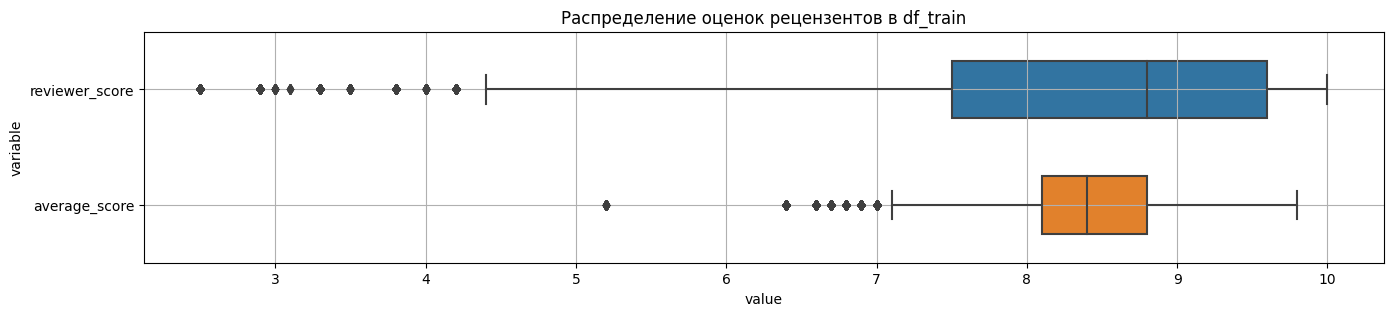

In [373]:
fig, axes = plt.subplots(figsize=(16, 3))
boxes = sns.boxplot(data=pd.melt(df_train[['reviewer_score','average_score']]),
            x="value", 
            y="variable",
            orient='h',
            width=0.5)
boxes.set_title('Распределение оценок рецензентов в df_train')
boxes.grid()

Рецензенты склонны давать положительные оценки. Но медианная средняя оценка явно ниже, чем медианная оценка, оставиленная рецензентами из исследуемой выборки. Так же есть выбросы в average_score, они могут отрицательно повлиять на модель, понадобится проверить результат с выбросами и без.

Посмотрим на эти же данные под другим углом, построив гистограммы.

Text(0.5, 1.0, 'Распределение количества средних оценок отеля')

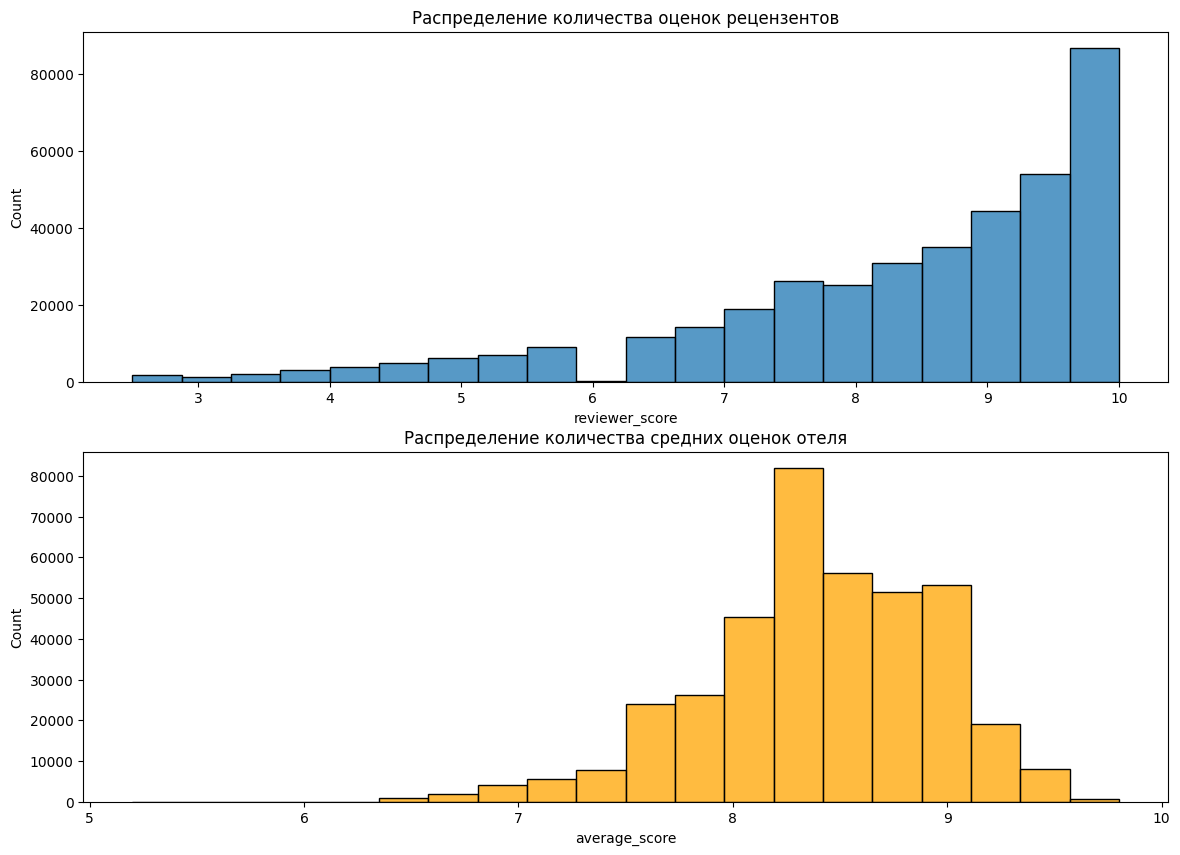

In [374]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
sns.histplot(data=df_train,
             x='reviewer_score',
             bins=20,
             ax=axes[0])
axes[0].set_title('Распределение количества оценок рецензентов')

sns.histplot(data=df_train,
             x='average_score',
             bins=20,
             color='orange',
             ax=axes[1])
axes[1].set_title('Распределение количества средних оценок отеля')

Средняя оценка распределена нормально, гистограмма коррелирует с коробчатой диаграммой, то же самое ожидается и от оценок рецензентов, но как раз они имеют перекос в сторону 10 баллов.

#### Зависимость оценок от других признаков

Продолжим исследование оценок, посмотрим на признак средней оценки (average_score) в разрезе других признаков.

Text(0.5, 1.0, 'Зависимость средней оценки от количества отзывов об отеле')

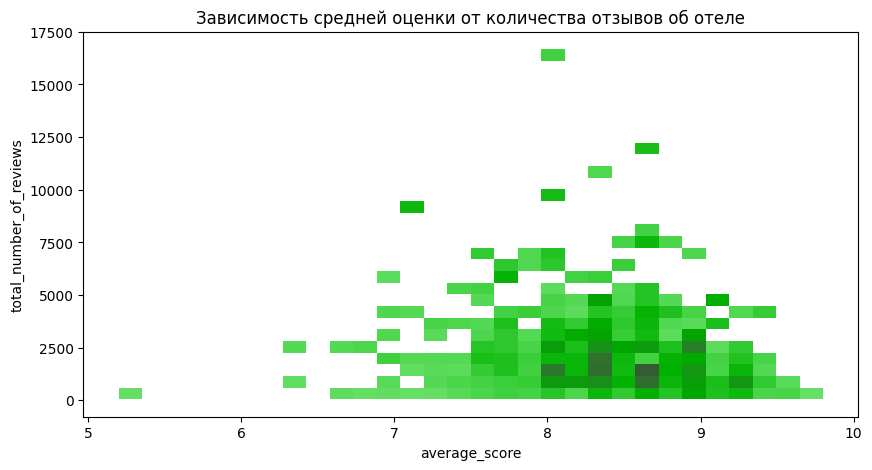

In [375]:
fig = plt.subplots(figsize=(10, 5))
histplot = sns.histplot(data=data,
                        x='average_score',
                        y='total_number_of_reviews',
                        bins=30,
                        color='green')
histplot.set_title('Зависимость средней оценки от количества отзывов об отеле')

Ожидаемая картина, наибольшая концентрация в медианной зоне средней оценки, но есть отели с очень большим количеством отзывов, скорее всего эти отзывы реальны, так как средние оценки, близки к медиане и даже ниже неё. Хотя существует вероятность, что так отели скрывают реально плохую оценку, накидывая большое количество положительных отзывов для компенсации негативных отзывов.

Text(0.5, 1.0, 'Зависимость выданной оценки от количества отзывов рецензента')

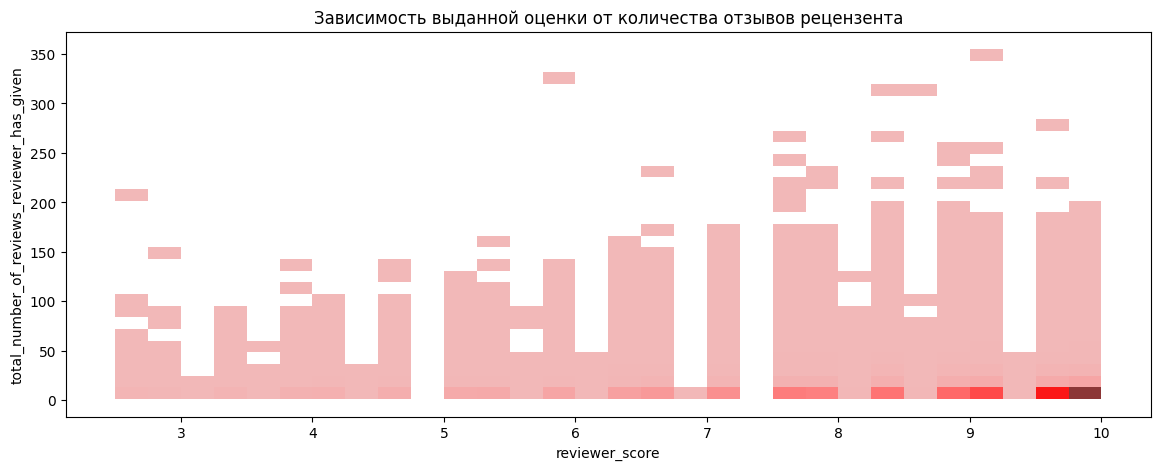

In [376]:
fig = plt.subplots(figsize=(14, 5))
histplot = sns.histplot(data=df_train,
                        x='reviewer_score',
                        y='total_number_of_reviews_reviewer_has_given',
                        bins=30,
                        color='red')
histplot.set_title('Зависимость выданной оценки от количества отзывов рецензента')

А вот это уже интересно, большая концентрация малого количества отзывов с хорошей оценкой. Может это фальшивые рецензенты, которые специально зраегистрировались, чтобы улучшить показания некоторых отелей.

In [377]:
# посмотрим какое количество отзывов сочетает высокую оценку и малое количество отзывов рецензента
data[(data['reviewer_score'] > 9.6) & (data['total_number_of_reviews_reviewer_has_given'] < 10)].shape[0]

71394

Посмотрим снова на оценку рецензента, но в разрезе количества отзывов об отеле.

Text(0.5, 1.0, 'Зависимость выданной оценки от количества отзывов об отеле')

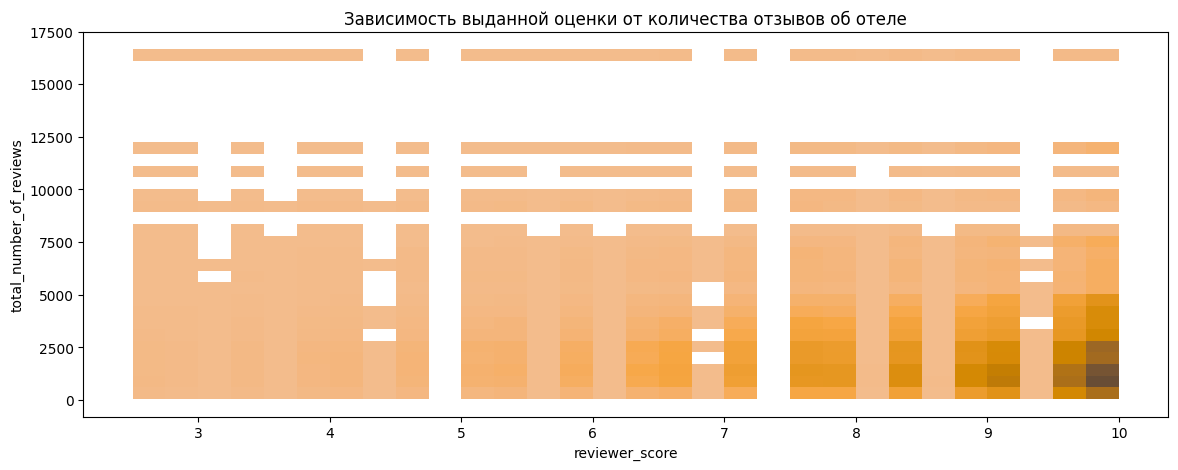

In [378]:
fig = plt.subplots(figsize=(14, 5))
histplot = sns.histplot(data=df_train,
                        x='reviewer_score',
                        y='total_number_of_reviews',
                        bins=30,
                        color='orange')
histplot.set_title('Зависимость выданной оценки от количества отзывов об отеле')

Ранее озвученное предположение о том, что отели с самым большим количеством оценок накручивают себе баллы скорее всего ложно, так как оценки рецензентов разпределены равномерно в верхней части графика, а вот в области от 0 до 5000 отзывов наблюдаются аномалии с большим количеством "десяток".

In [379]:
# посмотрим какое количество отзывов сочетает высокую оценку и малое количество отзывов об отеле
data[(data['reviewer_score'] > 9.6) & (data['total_number_of_reviews'] < 2400)].shape[0]

51284

Посмотрим, как оценка отелю рецензента зависит от количества оценок без отзывов.

Text(0.5, 1.0, 'Зависимость оценки рецензента от количества оценок без отзыва')

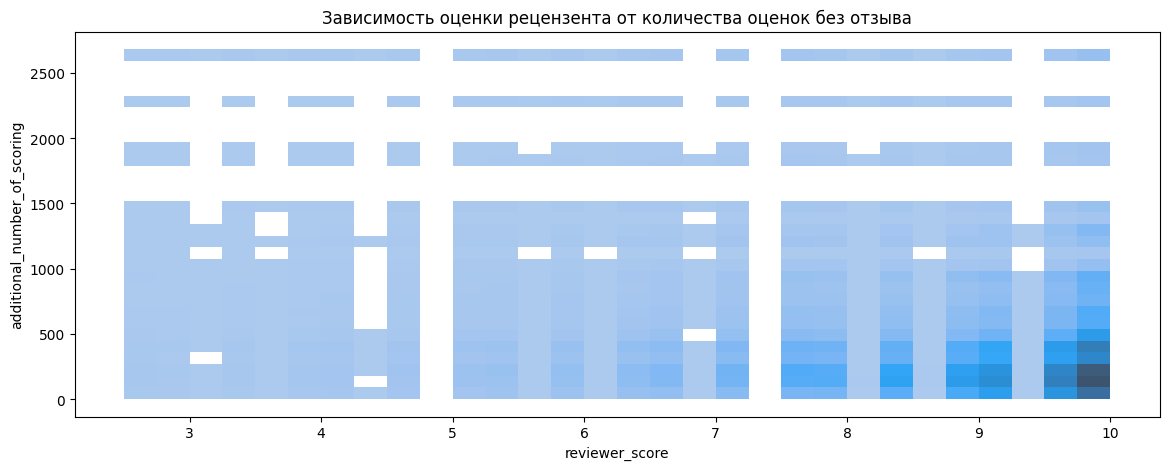

In [380]:
fig = plt.figure(figsize=(14, 5))
histplot = sns.histplot(data=df_train,
                              x='reviewer_score', 
                              y='additional_number_of_scoring',
                              bins=30)
histplot.set_title('Зависимость оценки рецензента от количества оценок без отзыва')

И снова аномальные "десятки", и снова у отелей с не самым большим количеством отзывов.

In [381]:
# посмотрим какое количество отзывов сочетает высокую оценку и малое количество отзывов без оценок
data[(data['reviewer_score'] > 9.6) & (data['additional_number_of_scoring'] < 400)].shape[0]

50449

Посмотрим еще, влияет ли страна рецензента на его оценку.

In [382]:
# для начала сформируем список стран рецензентов, которые встречаются более чем в 1.5% случаев
reviewer_country = df_train['reviewer_nationality'].value_counts(normalize=True) * 100
reviewer_country_list = list(reviewer_country[reviewer_country.values > 1.5].index)

# создадим функцию для преобразования стран
def reviewer_country_transform(country):
    if country not in reviewer_country_list:
        return 'other'
    else:
        return country.strip().lower()

# сформируем отдельный признак и применим к нему функцию    
df_train['reviewer_country'] = df_train['reviewer_nationality']  
df_train['reviewer_country'] = df_train['reviewer_country'].apply(reviewer_country_transform)

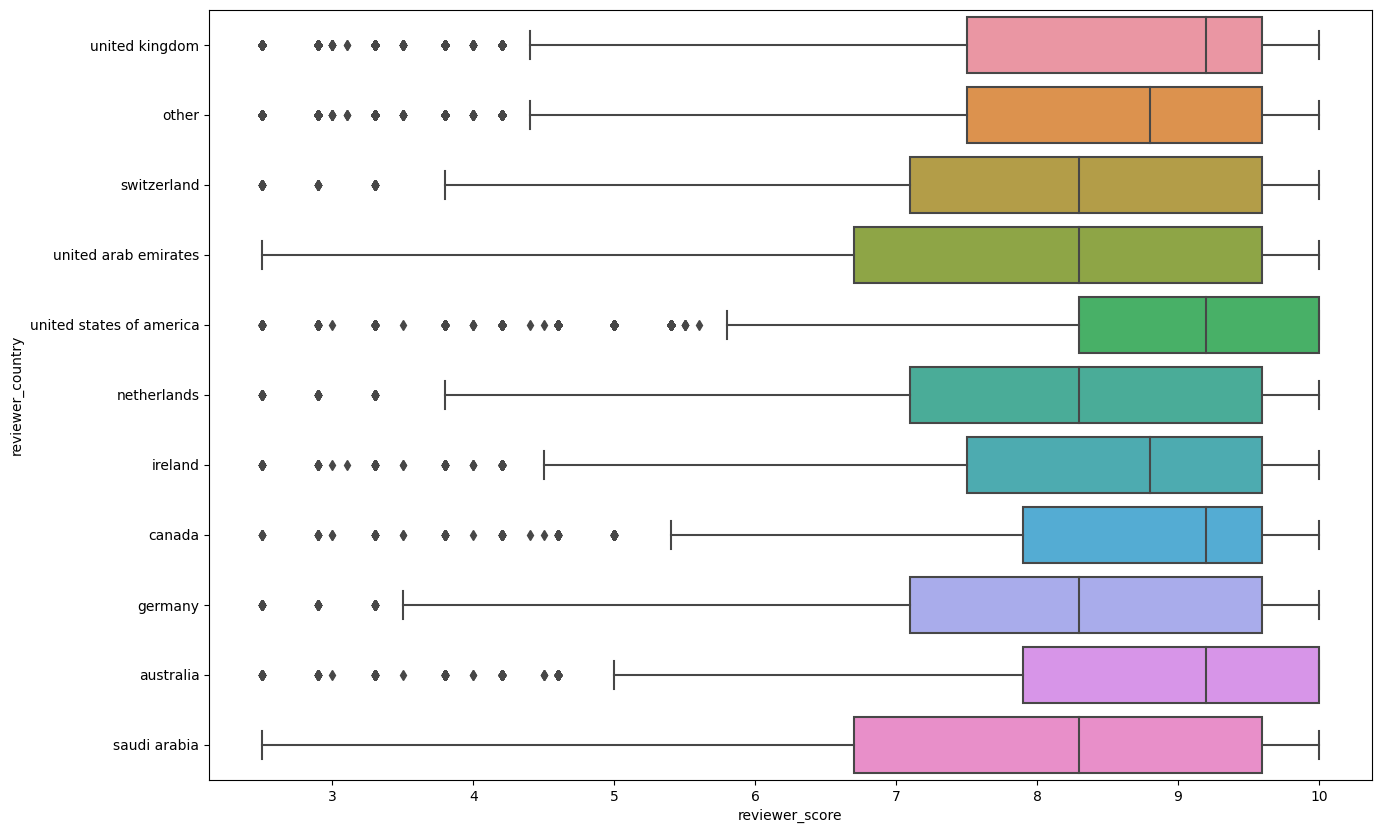

In [383]:
fig = plt.figure(figsize=(15, 10))
boxplot = sns.boxplot(data=df_train,
                      y='reviewer_country',
                      x='reviewer_score')

Австралия и США склонны к завышению. Великобритания, Ирландия и Канада так же имеют смещение медианы в сторону 9,5.
Страна рецензента может быть важным признаком, его обязательно нужно закодировать и проверить статистическое влияние.

Проверим связана ли оценка рецензента с временем жизни отзыва.

In [384]:
# для начала сделаем признак числовым, убрав слово day
# создадим функцию для преобразования признака    
def days_since_review_clean(days):
    """
    Функция предназначена для очистки признака days_since_review от слов day и days
    """
    days = days.strip()
    days = days.split()
    return int(days[0])
# применим функцию для преобразования признака
df_train['days_since_review'] = df_train['days_since_review'].apply(days_since_review_clean)

Text(0.5, 1.0, 'Зависимость выданной оценки от свежести отзыва')

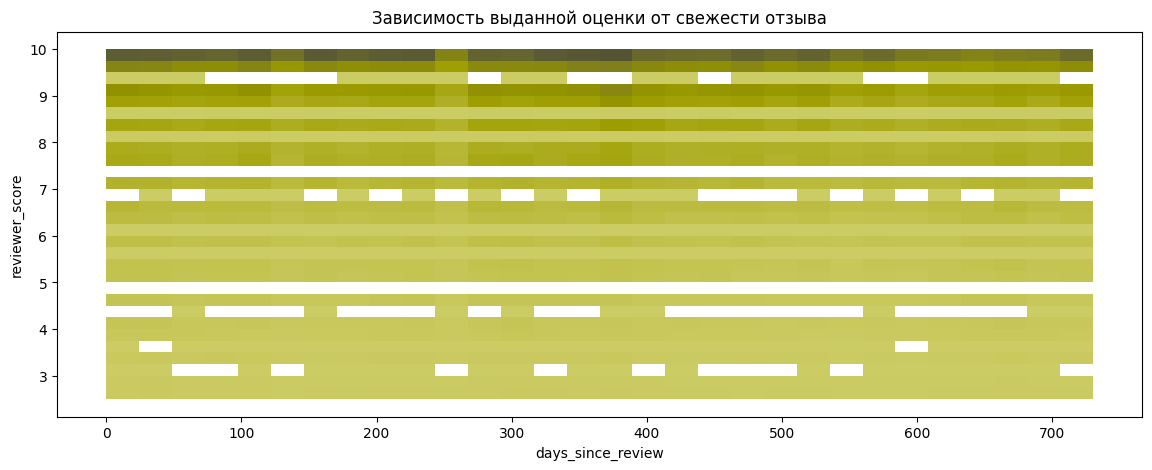

In [385]:
fig = plt.subplots(figsize=(14, 5))
histplot = sns.histplot(data=df_train,
                        y='reviewer_score',
                        x='days_since_review',
                        bins=30,
                        color='yellow')
histplot.set_title('Зависимость выданной оценки от свежести отзыва')

Аномалий не наблюдается, данный признак не похож на значимый.

### Формирование новых признаков и их проверка

#### Обработка дат

Перейдем к выделению признака дня недели, месяца и сезона.

In [386]:
# создадим из даты признак дня недели
data['review_day_of_week'] = data['review_date'].dt.dayofweek + 1
# создадим из даты признак месяца
data['review_month'] = data['review_date'].dt.month
# создадим из даты признак года
data['review_year'] = data['review_date'].dt.year
# создадим из месяца признак времени года (1-зима, 2-весна, 3-лето, 4-осень)
def review_season(month):
    if month in [1, 2, 12]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4
    
data['review_season'] = data['review_month'].apply(review_season)
# выведем шапку таблицы с созданными значениями
data[['review_date', 'review_day_of_week', 'review_month', 'review_season', 'review_year']].head()

,review_date,review_day_of_week,review_month,review_season,review_year
0,2017-07-21,5,7,3,2017
1,2016-12-12,1,12,1,2016
2,2015-11-26,4,11,4,2015
3,2015-10-17,6,10,4,2015
4,2016-05-16,1,5,2,2016


In [387]:
# так же применим ранее созданную функцию для преобразования признака days_since_review в датасете data
data['days_since_review'] = data['days_since_review'].apply(days_since_review_clean)

#### Название отеля

Названия отелей очень разнообразны. Но среди них попадаются сетевые популярные отели, которые могут следить за качеством более эффективно, чтобы поддерживать ценность бренда, а это в свою очередь может сказываться на оценке.

In [388]:
# уберем лишние пробелы по краям и переведем признак hotel_name  в нижжний регистр
data['hotel_name'] = data['hotel_name'].apply(lambda x: x.strip().lower())
# сформируме список всех популярный сетей отелей
list_of_popular_hotel_company = ['holliday inn', 'hilton', 'marriott', 'park plaza', 
                                 'park grand', 'crowne plaza', 'citizenm', 'radisson',
                                 'novotel', 'western', 'intercontinental',  'ritz',
                                 'hyatt', 'azimut', 'four seasons', 'millennium',
                                 'montcalm'
                                ]

# создадим функцию для формирования признака    
def popular_hotel_cpmpany_name(name):
    """Функция предназначена для формирования признака с названием сетевого отеля
    Args:
        name (string): название отеля
    """
    for company in list_of_popular_hotel_company:
        if company in name: 
            return company
    else:
        return 'other'

# при помощи функции формируем признак, содеражщий название популярной сети отелей       
data['popular_hotel_company'] = data['hotel_name'].apply(popular_hotel_cpmpany_name)
# выведем полученый результат в процентах
print(data['popular_hotel_company'].value_counts(normalize=True) * 100)

other               75.165879
hilton               6.881401
western              3.152764
park plaza           2.623619
radisson             2.181340
novotel              1.907558
park grand           1.452676
marriott             1.224653
millennium           1.129837
montcalm             1.017571
citizenm             1.011366
crowne plaza         0.943115
intercontinental     0.597590
hyatt                0.374803
ritz                 0.254005
four seasons         0.049638
azimut               0.032187
Name: popular_hotel_company, dtype: float64


Для получившихся отелей сделаем признак флаг, но после этого удалим отели, которые встречаются в менее чем 2% случаев, чтобы потом закодировать популярные сетевые.

In [389]:
# сделаем признак флаг
data['popular_hotel_company_flag'] = data['popular_hotel_company'].apply(lambda x: 0 if x =='other' else 1)

# сформируем список непопулярных сетевых отелей
list_of_nopopular_hotel_company = ['novotel', 'park grand', 'marriott', 'millennium',
                                   'montcalm', 'citizenm', 'crowne plaza', 'intercontinental', 
                                   'hyatt', 'ritz', 'four seasons', 'azimut'
                                  ]
# при помощи функции формируем признак, содеражщий название популярной сети отелей       
data['popular_hotel_company'] = data['popular_hotel_company'].apply(lambda x: 'other' if x in list_of_nopopular_hotel_company else x)
# выведем полученый результат в процентах
print(data['popular_hotel_company'].value_counts(normalize=True) * 100)

other         85.160876
hilton         6.881401
western        3.152764
park plaza     2.623619
radisson       2.181340
Name: popular_hotel_company, dtype: float64


#### Страна рецензента

Мы выше уже создавали функцию для выделения страны рецензента в df_train, применим эту функцию к data.

In [390]:
# сформируем отдельный признак и применим к нему функцию    
data['reviewer_country'] = data['reviewer_nationality']  
data['reviewer_country'] = data['reviewer_country'].apply(reviewer_country_transform)
# выведем полученый результат в процентах
print(data['reviewer_country'].value_counts(normalize=True) * 100)

united kingdom              47.552439
other                       28.322714
united states of america     6.871124
australia                    4.204848
ireland                      2.874909
united arab emirates         1.984535
saudi arabia                 1.735571
netherlands                  1.700864
switzerland                  1.682637
germany                      1.539735
canada                       1.530622
Name: reviewer_country, dtype: float64


#### Адрес отеля

Внутри каждого адреса есть информация о стране и о городе. Так как мы анализировали страны рецензентов, то интересно было бы сравнить со странами расположения отелей. На самом деле, признак страны рецензента нам и поможет, так как по сути в нем есть почти все страны. Так жи из адреса выделим город отеля.

In [391]:
# уберем лишние пробелы из признака reviewer_nationality и признака hotel_address
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip().lower())
data['hotel_address'] = data['hotel_address'].apply(lambda x: x.strip().lower())
# сфоримруем список стран из признака reviewer_nationality
all_countries = []
# в цикле добавим страны в список
for country in data['reviewer_nationality'].unique():
    all_countries.append(country)
    all_countries.append('austria')
    
# создадим функцию для формирования признака    
def hotel_country(address):
    """Функция предназначена для формирования признака страны расположения отеля
    Args:
        address (string): полный адрес отеля
    """
    for country in all_countries:
        if country in address: 
            return country
    else:
        return 'other'
    
# при помощи функции формируем признак, содеражщий страну отеля       
data['hotel_country'] = data['hotel_address'].apply(hotel_country)
# выведем полученый результат в процентах
print(data['hotel_country'].value_counts(normalize=True) * 100)
print('В датасете содержитя', len(data['hotel_country'].unique()), 'уникальных стран')

united kingdom    50.859351
spain             11.662705
france            11.619853
netherlands       11.093617
austria            7.550151
italy              7.214322
Name: hotel_country, dtype: float64
В датасете содержитя 6 уникальных стран


География расположения отелей не очень разнообразна. Больше всего отелей из Великобритании (50 %), Испания, Франция и Нидерланды имеют схожие показатели (11 %), Австрия и Италия тоже похожи между собой по количеству отелей (7 %).

Оставим этот признак, и дополнительно создадим признак-флаг, который показывает, если страна рецензента совпадает со страной расположения отеля.

In [392]:
# уберем лишние пробелы из признака reviewer_nationality
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
# создадим новый признак для флага, сначала поместим в него страну отеляи и страну рецензента
data['country_match_flag'] = data['hotel_country'] + '**' + data['reviewer_nationality']
# разделим страны на два самостоятельных элемента в списке
data['country_match_flag'] = data['country_match_flag'].apply(lambda x: x.split('**'))
# теперь создадим сам флаг, если элементы равны
data['country_match_flag'] = data['country_match_flag'].apply(lambda x: 1 if (x[0] == x[1]) else 0)
# посмотрим количество совпадений стран
data['country_match_flag'].value_counts(normalize=True) * 100

0    65.408211
1    34.591789
Name: country_match_flag, dtype: float64

In [393]:
# создадим список столиц и популярных городов указанных стран
all_cities = ['london', 'barcelona', 'madrid', 'paris', 'amsterdam', 'milan', 'vienna']
    
# создадим функцию для формирования признака    
def hotel_city(address):
    """Функция предназначена для формирования признака города расположения отеля
    Args:
        address (string): полный адрес отеля
    """
    for city in all_cities:
        if city in address:
            return city
    
    return 'other'
    
# при помощи функции формируем признак, содеражщий город расположения отеля       
data['hotel_city'] = data['hotel_address'].apply(hotel_city)
# выведем полученый результат в процентах
print(data['hotel_city'].value_counts(normalize=True) * 100)

london       50.859351
barcelona    11.662705
paris        11.619853
amsterdam    11.093617
vienna        7.550151
milan         7.214322
Name: hotel_city, dtype: float64


In [394]:
# добавим признаки населения страны, населения города и отношения между этими двумя показателями
dict_of_city_population = {'london': 8908081,
                           'barcelona': 1608680,
                           'paris': 2148327,
                           'amsterdam': 872757,
                           'vienna': 1867582,
                           'milan': 1378689                      
                          }

dict_of_country_population = {'united kingdom': 66273576,
                              'spain': 47394223,
                              'france': 68084217,
                              'netherlands': 17645800,
                              'austria': 8923507,
                              'italy': 59236213
                             }

# создадим функцию, которая расставит значение населения города к нужному отелю
def city_population(city):
    if city in dict_of_city_population.keys():
        return dict_of_city_population[city]
# создадим функцию, которая расставит значение населдения страны к нужному отелю
def country_population(country):
    if country in dict_of_country_population.keys():
        return dict_of_country_population[country]
    
# сформируем новые признаки
data['city_population'] = data['hotel_city'].apply(city_population)
data['country_population'] = data['hotel_country'].apply(country_population)
# создадим признак соотношения населения города и страны
data['population_ratio'] = data['city_population'] / data['country_population'] * 100

#### Координаты

Приступим к обработке координат. Уберем пропуски, добавим новые признаки для городов.

In [395]:
# создадим с координатами центров указанных городов
dict_of_coordinates = {'london': (51.500135, -0.126073),
                       'barcelona': (41.387094, 2.170091),
                       'paris': (48.860833, 2.337435),
                       'amsterdam': (52.372907, 4.891597),
                       'vienna': (48.205566, 16.363082),
                       'milan': (45.473315, 9.176671)                      
                      }
# создадим функцию, которая расставит координаты lat центра города, в котором расположен отель
def city_coordinates_lat(city):
    if city in dict_of_coordinates.keys():
        return dict_of_coordinates[city][0]
# создадим функцию, которая расставит координаты lat центра города, в котором расположен отель
def city_coordinates_lng(city):
    if city in dict_of_coordinates.keys():
        return dict_of_coordinates[city][1]
    
# сформируем новые признаки
data['city_center_lat'] = data['hotel_city'].apply(city_coordinates_lat)
data['city_center_lng'] = data['hotel_city'].apply(city_coordinates_lng)

In [396]:
# проверим уникальные отели, у которых нет координат
data[data.isna().any(axis=1)]['hotel_address'].unique()

array(['w hringer stra e 33 35 09 alsergrund 1090 vienna austria',
       'gr nentorgasse 30 09 alsergrund 1090 vienna austria',
       '23 rue damr mont 18th arr 75018 paris france',
       'josefst dter stra e 10 12 08 josefstadt 1080 vienna austria',
       'taborstra e 8 a 02 leopoldstadt 1020 vienna austria',
       'josefst dter stra e 22 08 josefstadt 1080 vienna austria',
       'bail n 4 6 eixample 08010 barcelona spain',
       'landstra er g rtel 5 03 landstra e 1030 vienna austria',
       '4 rue de la p pini re 8th arr 75008 paris france',
       '20 rue de la ga t 14th arr 75014 paris france',
       'w hringer stra e 12 09 alsergrund 1090 vienna austria',
       'savoyenstra e 2 16 ottakring 1160 vienna austria',
       'pau clar s 122 eixample 08009 barcelona spain',
       'sieveringer stra e 4 19 d bling 1190 vienna austria',
       'paragonstra e 1 11 simmering 1110 vienna austria',
       'hasenauerstra e 12 19 d bling 1190 vienna austria',
       'sep lveda 180 eix

In [397]:
# так как уникальных адресов без координат немного - 17, то их координаты можно обработать руками, поискав координаты в интернете
dict_of_lost_coordinates = {'w hringer stra e 33 35 09 alsergrund 1090 vienna austria': (48.220403, 16.355818),
                            'gr nentorgasse 30 09 alsergrund 1090 vienna austria': (48.220885, 16.366606),
                            '23 rue damr mont 18th arr 75018 paris france': (48.888982, 2.333107),
                            'josefst dter stra e 10 12 08 josefstadt 1080 vienna austria': (48.209386, 16.353372),
                            'taborstra e 8 a 02 leopoldstadt 1020 vienna austria': (48.213607, 16.379875),
                            'josefst dter stra e 22 08 josefstadt 1080 vienna austria': (48.209691, 16.351484),
                            'bail n 4 6 eixample 08010 barcelona spain': (41.391646, 2.177877),
                            'landstra er g rtel 5 03 landstra e 1030 vienna austria': (48.188887, 16.383801),
                            '4 rue de la p pini re 8th arr 75008 paris france': (48.875373, 2.323381),
                            '20 rue de la ga t 14th arr 75014 paris france': (48.840036, 2.323576),
                            'w hringer stra e 12 09 alsergrund 1090 vienna austria': (48.216904, 16.359998),
                            'savoyenstra e 2 16 ottakring 1160 vienna austria': (48.219590, 16.285613),
                            'pau clar s 122 eixample 08009 barcelona spain': (41.392748, 2.167397),
                            'sieveringer stra e 4 19 d bling 1190 vienna austria': (48.246029, 16.341540),
                            'paragonstra e 1 11 simmering 1110 vienna austria': (48.186808, 16.420725),
                            'hasenauerstra e 12 19 d bling 1190 vienna austria': (48.233580, 16.345506),
                            'sep lveda 180 eixample 08011 barcelona spain': (41.385916, 2.154178)
                           }
# создадим функцию, которая расставит пропущенные координаты lat
def lost_coordinates_lat(address):
    if address in dict_of_lost_coordinates.keys():
        return dict_of_lost_coordinates[address][0]
    else:
        pass
# создадим функцию, которая расставит пропущенные координаты lat
def lost_coordinates_lng(address):
    if address in dict_of_lost_coordinates.keys():
        return dict_of_lost_coordinates[address][1]
    else:
        pass
    
# сформируем новые признаки
data['lost_lat'] = data['hotel_address'].apply(lost_coordinates_lat)
data['lost_lng'] = data['hotel_address'].apply(lost_coordinates_lng)

In [398]:
# заполним пропуски
data = data.fillna({'lat': data['lost_lat'], 'lng': data['lost_lng']})
# удалим вспомогательные колоник
data.drop(['lost_lat', 'lost_lng'], axis=1, inplace=True)

In [399]:
# создадим признаки удаленности от центра города, это позволит сравнивать их вне зависимости от города 
data['delta_lat'] = abs(data['lat'] - data['city_center_lat']) * 62.58663
data['delta_lng'] = abs(data['lng'] - data['city_center_lng']) * 111.13486

In [400]:
# географическая долгота содержит отрицательные значения, избавимся от них увеличив все значения на 1
data['lng'] = data['lng'].apply(lambda x: x + 1)
data['city_center_lng'] = data['city_center_lng'].apply(lambda x: x + 1)

#### Теги

Попробуем выделить из тегов полезную информацию, сначала посмотрим на саи теги, найдем количество уникальных и самые популярные.

In [401]:
# Обработаем строку с тегами, избавимся от лишних символов
list_of_symb = ["[' ", " ']", " ' ", " '"]
unique_tags_list = []
tags_list = data['tags'].values
# сфоримруем список с тегами
for tags in tags_list:
    for symbol in list_of_symb:
        tags = tags.replace(symbol, '')
    tags = tags.split(',')
    for tag in tags:
        unique_tags_list.append(tag)

In [402]:
# посмотрим на самые популярные теги
tags_counter = Counter(unique_tags_list)
print('Самый часто встречающийся тег:', tags_counter.most_common(1)[0][0])
print()
print('30 самых популярных тегов:')
for popular_tag in tags_counter.most_common(30):
    print(popular_tag[0])

Самый часто встречающийся тег: Leisure trip

30 самых популярных тегов:
Leisure trip
Submitted from a mobile device
Couple
Stayed 1 night
Stayed 2 nights
Solo traveler
Stayed 3 nights
Business trip
Group
Family with young children
Stayed 4 nights
Double Room
Standard Double Room
Superior Double Room
Family with older children
Deluxe Double Room
Double or Twin Room
Stayed 5 nights
Standard Double or Twin Room
Classic Double Room
Superior Double or Twin Room
2 rooms
Stayed 6 nights
Standard Twin Room
Single Room
Twin Room
Stayed 7 nights
Executive Double Room
Classic Double or Twin Room
Superior Twin Room


Можно выделить признаки по количеству ночей, которые рецензент провел в отеле. Так же стоит добавить флаги для рабочей поездки и поездки для отдыха.

In [403]:
night_tags_list = []

for tag in unique_tags_list:
    if 'night' in tag:
        night_tags_list.append(tag)
         
tags_of_night_counter = Counter(night_tags_list)
print('Самый часто встречающийся тег о количестве ночей в отеле:', tags_of_night_counter.most_common(1)[0][0])

Самый часто встречающийся тег о количестве ночей в отеле: Stayed 1 night


In [404]:
# выделим из тегов информацию о количестве ночей в отеле
def nights_column_create(tags):
    """Функция предназначена для формирования признака, показывающего, сколько ночей рецензент провел в отеле
    Args:
        tags (string): теги, которыми рецензент пометил своё пребывание в отеле
    """
    list_of_symb = ["[' ", " ']", " ' ", " '"]
   
    for symbol in list_of_symb:
        tags = tags.replace(symbol, '')
    tags_list = tags.split(',')
    
    for tag in tags_list:
        if 'night' in tag: 
            tag_word_list = tag.split()   
            for word in tag_word_list:
                if word.isdigit():
                    return word
    
# при помощи функции формируем признак, содеражщий количество ночей, проведнных в отеле       
data['nights_amount'] = data['tags'].apply(nights_column_create)
data = data.fillna({'nights_amount': 0})
data['nights_amount'] = data['nights_amount'].astype('int8')

# при помощи функции пометим все значения больше 9 ночей как 10
data['nights_amount'] = data['nights_amount'].apply(lambda x: 10 if x > 9 else x)

In [405]:
# форимруем список поулярных тегов, но без информации о ночах
popular_tags_list = ['Leisure trip', 'Submitted from a mobile device', 'Couple', 'Solo traveler', 
                     'Business trip', 'Group', 'Family with young children', ' Double Room', 
                     'Standard Double Room', 'Superior Double Room', 'Family with older children',
                     'Deluxe Double Room', 'Double or Twin Room', 'Standard Double or Twin Room', 
                     'Classic Double Room', 'Superior Double or Twin Room', '2 rooms', 
                     'Standard Twin Room', 'Single Room', 'Twin Room', 'Executive Double Room',
                     'Classic Double or Twin Room', 'Superior Twin Room']

# создадим для каждого тега отдельный признак
for tag in popular_tags_list:
    data[tag.lower().strip()] = data['tags'].apply(lambda x: 1 if tag in x else 0)

#### Отзывы

Теперь приступим к самому сложному этапу - анлизу отзывов. Суть в том, что даже при отсуствии негатива или позитива, рецензент может заполнить эти поля.

In [406]:
# уберем лишние пробелы из признака negative_review и выведем на экран 30 самых популярных
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
negative_review = Counter(data['negative_review'])
negative_review.most_common(30)

[('no negative', 127890),
 ('nothing', 21185),
 ('n a', 1815),
 ('none', 1501),
 ('', 849),
 ('nothing really', 656),
 ('small room', 570),
 ('all good', 545),
 ('breakfast', 545),
 ('no complaints', 523),
 ('location', 502),
 ('nothing at all', 467),
 ('everything', 420),
 ('nothing to dislike', 373),
 ('price', 348),
 ('nil', 332),
 ('small rooms', 307),
 ('everything was perfect', 276),
 ('na', 272),
 ('can t think of anything', 250),
 ('leaving', 244),
 ('absolutely nothing', 242),
 ('everything was great', 222),
 ('expensive', 206),
 ('nothing to complain about', 205),
 ('no', 200),
 ('room size', 200),
 ('very small room', 200),
 ('nothing not to like', 185),
 ('nothing all good', 181)]

Мы видим, самыми популярными являются различные отзывы показывающие, что негатив нет. Попробуем сделать новый признак-флаг no_negative

In [407]:
# сформруем список популярных отзывов, которые говорят об отсуствии негатива
list_of_nothing_negative = ['no negative', 'nothing', 'n a', 'nothing really', 'all good', 
                            'no complaints', 'nothing at all', 'nothing to dislike', 
                            'nothing to dislike', 'nil', 'everything was perfect', 'na',
                            'can t think of anything', 'absolutely nothing', 'everything was great', 
                            'nothing to complain about', 'no', 'nothing not to like', 'nothing all good']
# создадим функцию, которая поставит флаг в признак no_neagtive
def no_negative_flag_create(negative_review_text):
    if len(negative_review_text) > 0:
        for review in list_of_nothing_negative:
            if review == negative_review_text:
                return 1
    else:
        return 1
        
data['no_negative'] = data['negative_review'].apply(no_negative_flag_create)
# теперь заполним пропуски в признаке нулями
data = data.fillna({'no_negative': 0})
data['no_negative'] = data['no_negative'].astype('int8')
# отобразим значения признака no_nagtive
print(data['no_negative'].value_counts())

0    359070
1    156668
Name: no_negative, dtype: int64


In [408]:
# при помощи функции формируем флаги-признаки из популярных негативных отзывов
data['bad_room'] = data['negative_review'].apply(lambda x: 1 if 'room' in x else 0)
print(data['bad_room'].value_counts(normalize=True) * 100)

data['bad_breakfast'] = data['negative_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
print(data['bad_breakfast'].value_counts(normalize=True) * 100)

data['bad_location'] = data['negative_review'].apply(lambda x: 1 if 'location' in x else 0)
print(data['bad_location'].value_counts(normalize=True) * 100)

0    69.293323
1    30.706677
Name: bad_room, dtype: float64
0    90.284602
1     9.715398
Name: bad_breakfast, dtype: float64
0    97.878574
1     2.121426
Name: bad_location, dtype: float64


Проделаем то же самое и с положительными отзывами.

In [409]:
# уберем лишние пробелы из признака positive_review и выведем на экран 30 самых популярных
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())
negative_review = Counter(data['positive_review'])
negative_review.most_common(30)

[('no positive', 35946),
 ('location', 11945),
 ('everything', 3314),
 ('nothing', 1731),
 ('great location', 1687),
 ('the location', 1606),
 ('good location', 1496),
 ('breakfast', 795),
 ('friendly staff', 733),
 ('excellent location', 639),
 ('staff', 553),
 ('location and staff', 452),
 ('location staff', 432),
 ('location location location', 345),
 ('location was great', 328),
 ('good breakfast', 316),
 ('everything was perfect', 316),
 ('location was good', 312),
 ('comfy bed', 303),
 ('perfect location', 287),
 ('the staff', 281),
 ('location is great', 280),
 ('location is good', 256),
 ('all', 250),
 ('clean', 237),
 ('every thing', 235),
 ('very friendly staff', 233),
 ('great breakfast', 222),
 ('breakfast was good', 220),
 ('excellent breakfast', 218)]

In [410]:
list_of_nothing_positive = ['no positive', ' nothing']

# создадим функцию, которая поставит флаг в признак no_positive
def no_positive_flag_create(positive_review_text):
    if len(positive_review_text) > 0:
        for review in list_of_nothing_positive:
            if review == positive_review_text:
                return 1
    else:
        return 1       

data['no_positive'] = data['positive_review'].apply(no_positive_flag_create)

# теперь заполним пропуски в признаке нулями
data = data.fillna({'no_positive': 0})
data['no_positive'] = data['no_positive'].astype('int8')

# отобразим значения признака no_positive
print(data['no_positive'].value_counts())

0    479609
1     36129
Name: no_positive, dtype: int64


In [411]:
# при помощи функции формируем флаги-признаки из популярных негативных отзывов
data['good_staff'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x else 0)
print(data['good_staff'].value_counts(normalize=True) * 100)

data['good_breakfast'] = data['positive_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
print(data['good_breakfast'].value_counts(normalize=True) * 100)

data['good_location'] = data['positive_review'].apply(lambda x: 1 if 'location' in x else 0)
print(data['good_location'].value_counts(normalize=True) * 100)

0    63.260221
1    36.739779
Name: good_staff, dtype: float64
0    83.975003
1    16.024997
Name: good_breakfast, dtype: float64
0    63.250526
1    36.749474
Name: good_location, dtype: float64


В признаках показывающих длину отзывов есть ошибки, поэтому пересоздадим их заново

In [412]:
# рассчитаем длину отзыва
data['len_positive_review'] = data['positive_review'].apply(lambda x: len(x))

# рассчитаем длину отзыва
data['len_negative_review'] = data['negative_review'].apply(lambda x: len(x))

# добавим соотношение длины позитивных и негативных отзывов
data['len_ratio'] =  data['len_positive_review'].apply(lambda x: 0.01 if x == 0 else x)
data['len_ratio'] = round(data['len_negative_review'] / data['len_ratio'], 3)
data['len_ratio'] = data['len_ratio'].astype('float64')

А теперь удалим из отзывов ненегавтиыне и непозитивные слова и снова рассчитаем длину отзывов.

In [413]:
# для анализа эмоциональности слов, удалим из позитивных и негативных отзывов "мусорные" значения
data['positive_review'] = data['positive_review'].apply(lambda x: '' if x in list_of_nothing_positive else x)
data['negative_review'] = data['negative_review'].apply(lambda x: '' if x in list_of_nothing_negative else x)

In [414]:
# рассчитаем длину отзыва
data['real_len_positive_review'] = data['positive_review'].apply(lambda x: len(x))
# рассчитаем длину отзыва
data['real_len_negative_review'] = data['negative_review'].apply(lambda x: len(x))

# склеиваем отзывы в одном признаке
data['all_review'] = data['negative_review'] + ' ' + data['positive_review']
# рассчитаем длину отзыва
data['len_all_review'] = data['all_review'].apply(lambda x: len(x))

# добавим соотношение длины позитивных и негативных отзывов
data['real_len_ratio'] =  data['real_len_positive_review'].apply(lambda x: 0.01 if x == 0 else x)
data['real_len_ratio'] = round(data['real_len_negative_review'] / data['real_len_ratio'], 3)
data['real_len_ratio'] = data['real_len_ratio'].astype('float64')

На этом можно было бы остановиться, но попробуем применить рекомендованый способ анализа текста на наличе реальных негативных, позитивных и т.п. слов.

Для этого вспользуемся методом SentimentIntensityAnalyzer из библиотеки NLTK.

Напишем функцию, которая создаст новые признаки с количеством негативных, позитивных и нейтральных слов. Для анализа ииспользуем савокупный положительный и негативный отзыв.

При подготовке данных так е решим задачу с указанием верной длины отзыва.

In [415]:
# применяем SentimentIntensityAnalyzer ко всему отзыву, в результате получаем словарь
sent_analyzer = SentimentIntensityAnalyzer()
data['words_analysis'] = data['all_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# забираем их словаря соответствующие коэффициенты эмоционлаьной окраски
data['neg_words_analysis'] = data['words_analysis'].apply(lambda x: x['neg'])
data['neu_words_analysis'] = data['words_analysis'].apply(lambda x: x['neu'])
data['pos_words_analysis'] = data['words_analysis'].apply(lambda x: x['pos'])
data['compound_words_analysis'] = data['words_analysis'].apply(lambda x: x['compound'])

In [416]:
# теперь полученный коэффициент умножим на длину отзыва, чтобы получить количество слов с эмоциональным оттенком
data['len_neg_words'] = data['neg_words_analysis'] * data['len_all_review']
data['len_neu_words'] = data['neu_words_analysis'] * data['len_all_review']
data['len_pos_words'] = data['pos_words_analysis'] * data['len_all_review']
data['len_compound_words'] = data['compound_words_analysis'] * data['len_all_review']

### Очистка от выбросов

В показателях есть "выбросы", которые могут негативно сказаться на работе модели. Проведем очистку.

Скажу честно, тут оставлены только те признаки, обработка которых улучшила финальные результаты.

In [417]:
# очистка от выбросов
data['additional_number_of_scoring'] = data['additional_number_of_scoring'].apply(lambda x: x if x < 1550 else 1550)

### Отбор признаков

На данном этапе удалось сформировать достаточное количество признаков, которые имеют влияние на целевой показатель. Теперь для более качественной работы модели нужно провести кодирование, нормализацию и/или стандартизацию признаков. Для начала посмотрим на данные, которые у нас получились и удалим те, которые нам не нужны.

In [418]:
# формируем список object-столбцов для удаления
drop_columns = ['hotel_address', 'review_date', 'hotel_name', 'review_total_negative_word_counts',
                'negative_review', 'positive_review', 'tags', 'review_total_positive_word_counts',
                'all_review', 'words_analysis', 'reviewer_nationality', 'hotel_country', 'hotel_city'
               ]
# удаляем столбцы
data.drop(drop_columns, axis = 1, inplace=True)

Попробуем закодировать номинальные признаки. Порядковое кодирование плохо работает для номинальных признаков. Воспользуемся методом однократного кодирования. Метод однократного кодирования реализован в pandas в функции pd.get_dummies(). Для выполнения кодирования достаточно передать в функцию DataFrame и указать столбцы, для которых должно выполняться кодирование. По умолчанию кодирование выполняется для всех столбцов типа object, а это нам и нужно.

In [419]:
# закодируем все столбцы с типом object
data = pd.get_dummies(data)

#### Тесты на статистическую значимость

Пришло время проверки статистической значимости созданных признаков. Для начала разделим признаки по типу.


In [420]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
             'days_since_review', 'city_population', 'country_population', 'population_ratio', 
             'len_positive_review', 'len_negative_review', 'len_ratio', 'real_len_positive_review', 'real_len_negative_review', 
             'real_len_ratio', 'len_all_review', 'neg_words_analysis', 'neu_words_analysis', 'pos_words_analysis', 'compound_words_analysis',
             'len_neg_words', 'len_neu_words', 'len_pos_words', 'len_compound_words'
           ]

# категориальные и бинарные признаки
cat_cols = ['average_score', 'review_day_of_week', 'review_month', 'review_season', 'review_year', 'popular_hotel_company_flag', 
            'lat', 'lng', 'city_center_lat', 'city_center_lng', 'delta_lat', 'delta_lng',         
            'no_negative', 'bad_room', 'bad_breakfast', 'bad_location', 'no_positive', 'good_staff', 'good_breakfast', 'good_location', 
            'nights_amount', 'leisure trip', 'submitted from a mobile device', 'couple', 'solo traveler', 
            'business trip', 'group', 'family with young children', 'double room', 'standard double room', 'superior double room', 
            'family with older children', 'deluxe double room', 'double or twin room', 'standard double or twin room', 
            'classic double room', 'superior double or twin room', '2 rooms', 'standard twin room', 'single room', 
            'twin room', 'executive double room', 'classic double or twin room', 'superior twin room', 
            'popular_hotel_company_hilton', 'popular_hotel_company_other', 'popular_hotel_company_park plaza', 
            'popular_hotel_company_radisson', 'popular_hotel_company_western', 'reviewer_country_australia', 
            'reviewer_country_canada', 'reviewer_country_germany', 'reviewer_country_ireland', 'reviewer_country_netherlands', 
            'reviewer_country_other', 'reviewer_country_saudi arabia', 'reviewer_country_switzerland', 
            'reviewer_country_united arab emirates', 'reviewer_country_united kingdom', 'reviewer_country_united states of america'
           ]

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<AxesSubplot:>

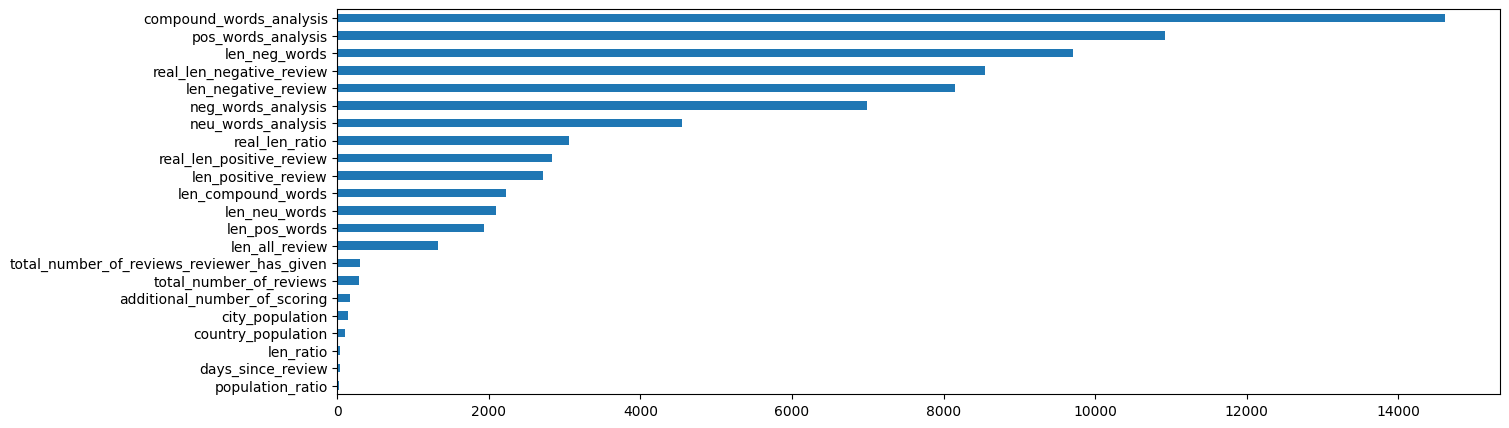

In [421]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

plt.rcParams['figure.figsize'] = (15, 5)
imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Удаление незначимых признаков ведет к снижению качества работы модели. Поэтому оставляем их.

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике.

<AxesSubplot:>

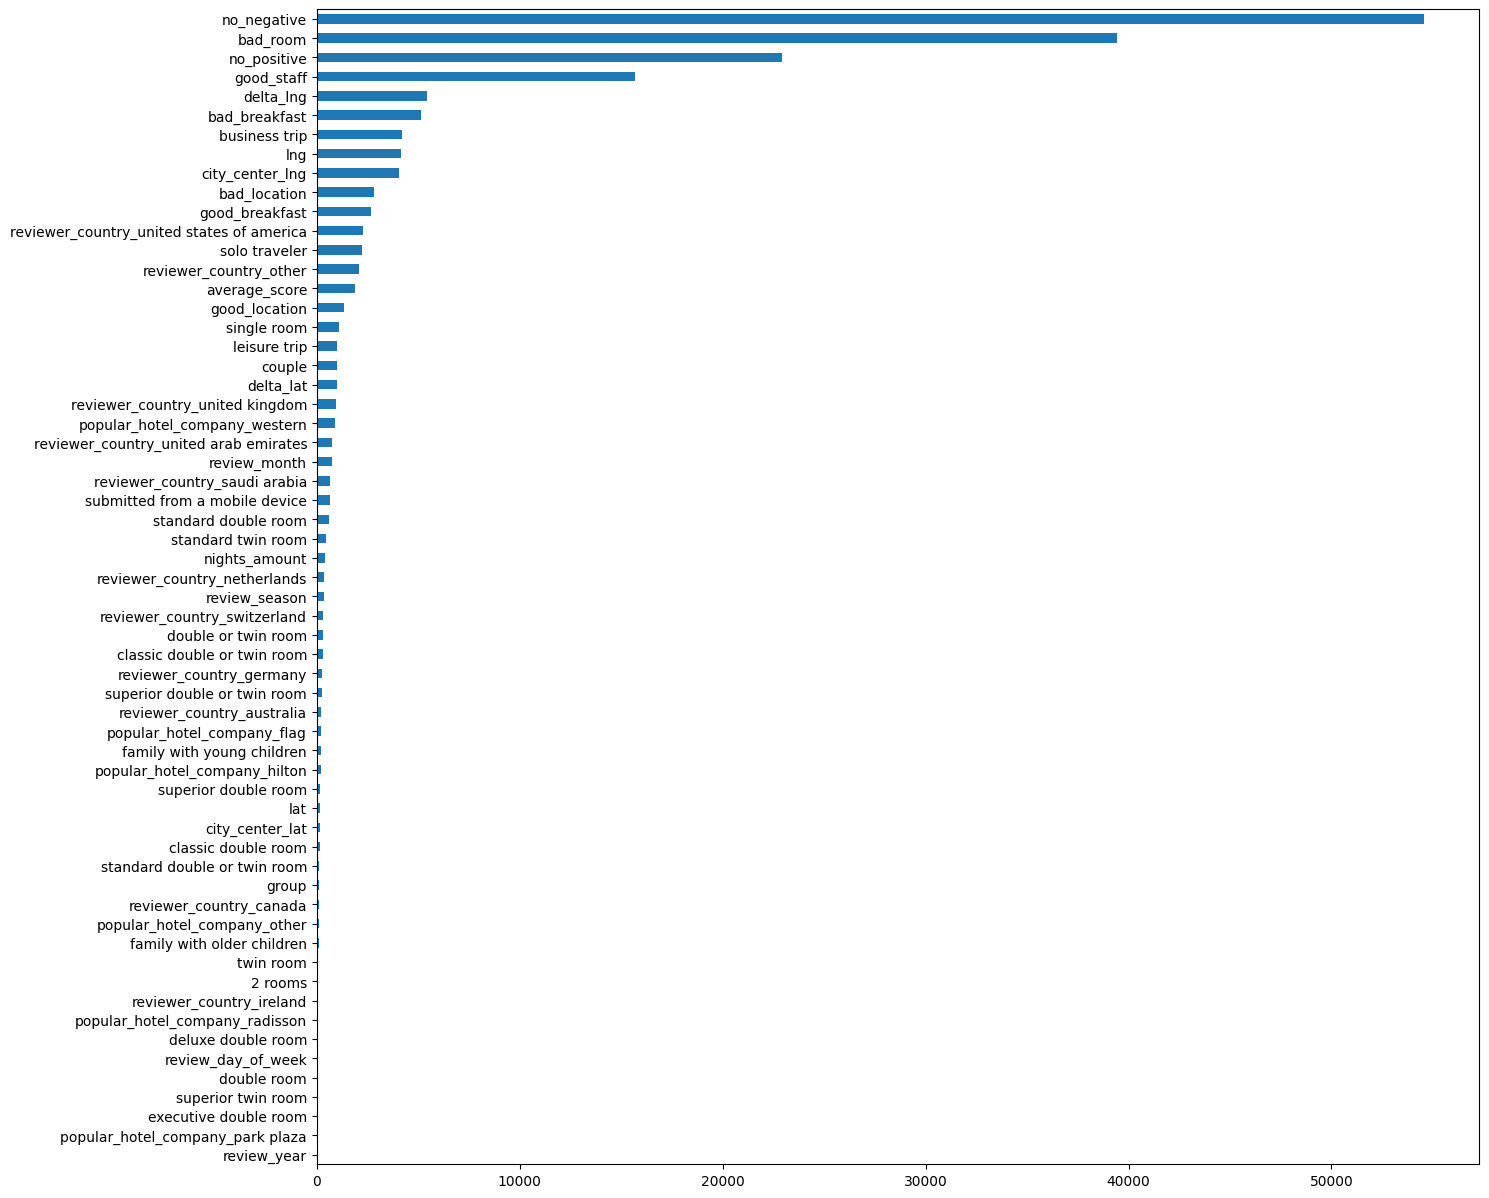

In [422]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15, 15)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [423]:
# удаляем столбцы, которые не имеют сильного влияния
data.drop(['review_year', 'popular_hotel_company_park plaza', 
           'executive double room', 'superior twin room', 
           'double room', 'review_day_of_week', 'deluxe double room',
           'popular_hotel_company_radisson', 'reviewer_country_ireland',
           '2 rooms', 'twin room'
          ],
           axis = 1, inplace=True
         )

#### Проверка корреляции

Посмотрим на признаки, которые имеют сильную корреляцию друг с другом.

In [424]:
# создадим таблицу со значениями корреляции между признаками
corr_data = data.corr()
# создадим пустой список, куда будем добавлять признкаи с высокой корреляцией
list_of_corr = []
# пройдем цикклом по таблице и добавим в список нужные признаки
for col in corr_data.columns:
    for i in corr_data[col]:
        if 0.9 <= abs(i) < 1:
            list_of_corr.append((col, i))

# создадим список для пар признаков с высокой корреляцией
list_of_corr_couple = []          
# в цикле добавим в список пары признаков с высокой корреляцией
for i in list_of_corr:
    for j in list_of_corr:
        if i[0] != j[0]:
            if i[1] == j[1]:
                list_of_corr_couple.append((i[0], j[0], j[1]))
            
# выведем пары признаков с высокой корреляцией
for i in list_of_corr_couple:
    print(i)            

('lat', 'city_center_lat', 0.999986665138759)
('lng', 'city_center_lng', 0.9999444843449956)
('sample', 'reviewer_score', 0.9317530774180254)
('reviewer_score', 'sample', 0.9317530774180254)
('city_center_lat', 'lat', 0.999986665138759)
('city_center_lng', 'lng', 0.9999444843449956)
('leisure trip', 'business trip', -0.9040337997914786)
('business trip', 'leisure trip', -0.9040337997914786)
('len_positive_review', 'real_len_positive_review', 0.9997184017035093)
('len_negative_review', 'real_len_negative_review', 0.9995295686805635)
('real_len_positive_review', 'len_positive_review', 0.9997184017035093)
('real_len_negative_review', 'len_negative_review', 0.9995295686805635)
('len_all_review', 'len_neu_words', 0.9884944664233014)
('len_neu_words', 'len_all_review', 0.9884944664233014)


In [425]:
# удаляем столбцы, которые не имеют высокую корреляцию между собой
data.drop(['city_center_lat', 'city_center_lng', 'no_positive'],axis = 1, inplace=True)

На самом деле видно, что признаков с высокой корреляцией много, однако удаление других мультиколлиниарных признаков ухудшило результаты работы модели, поэтому оставляем как есть.

Построим график корреляции для визульной проверки.

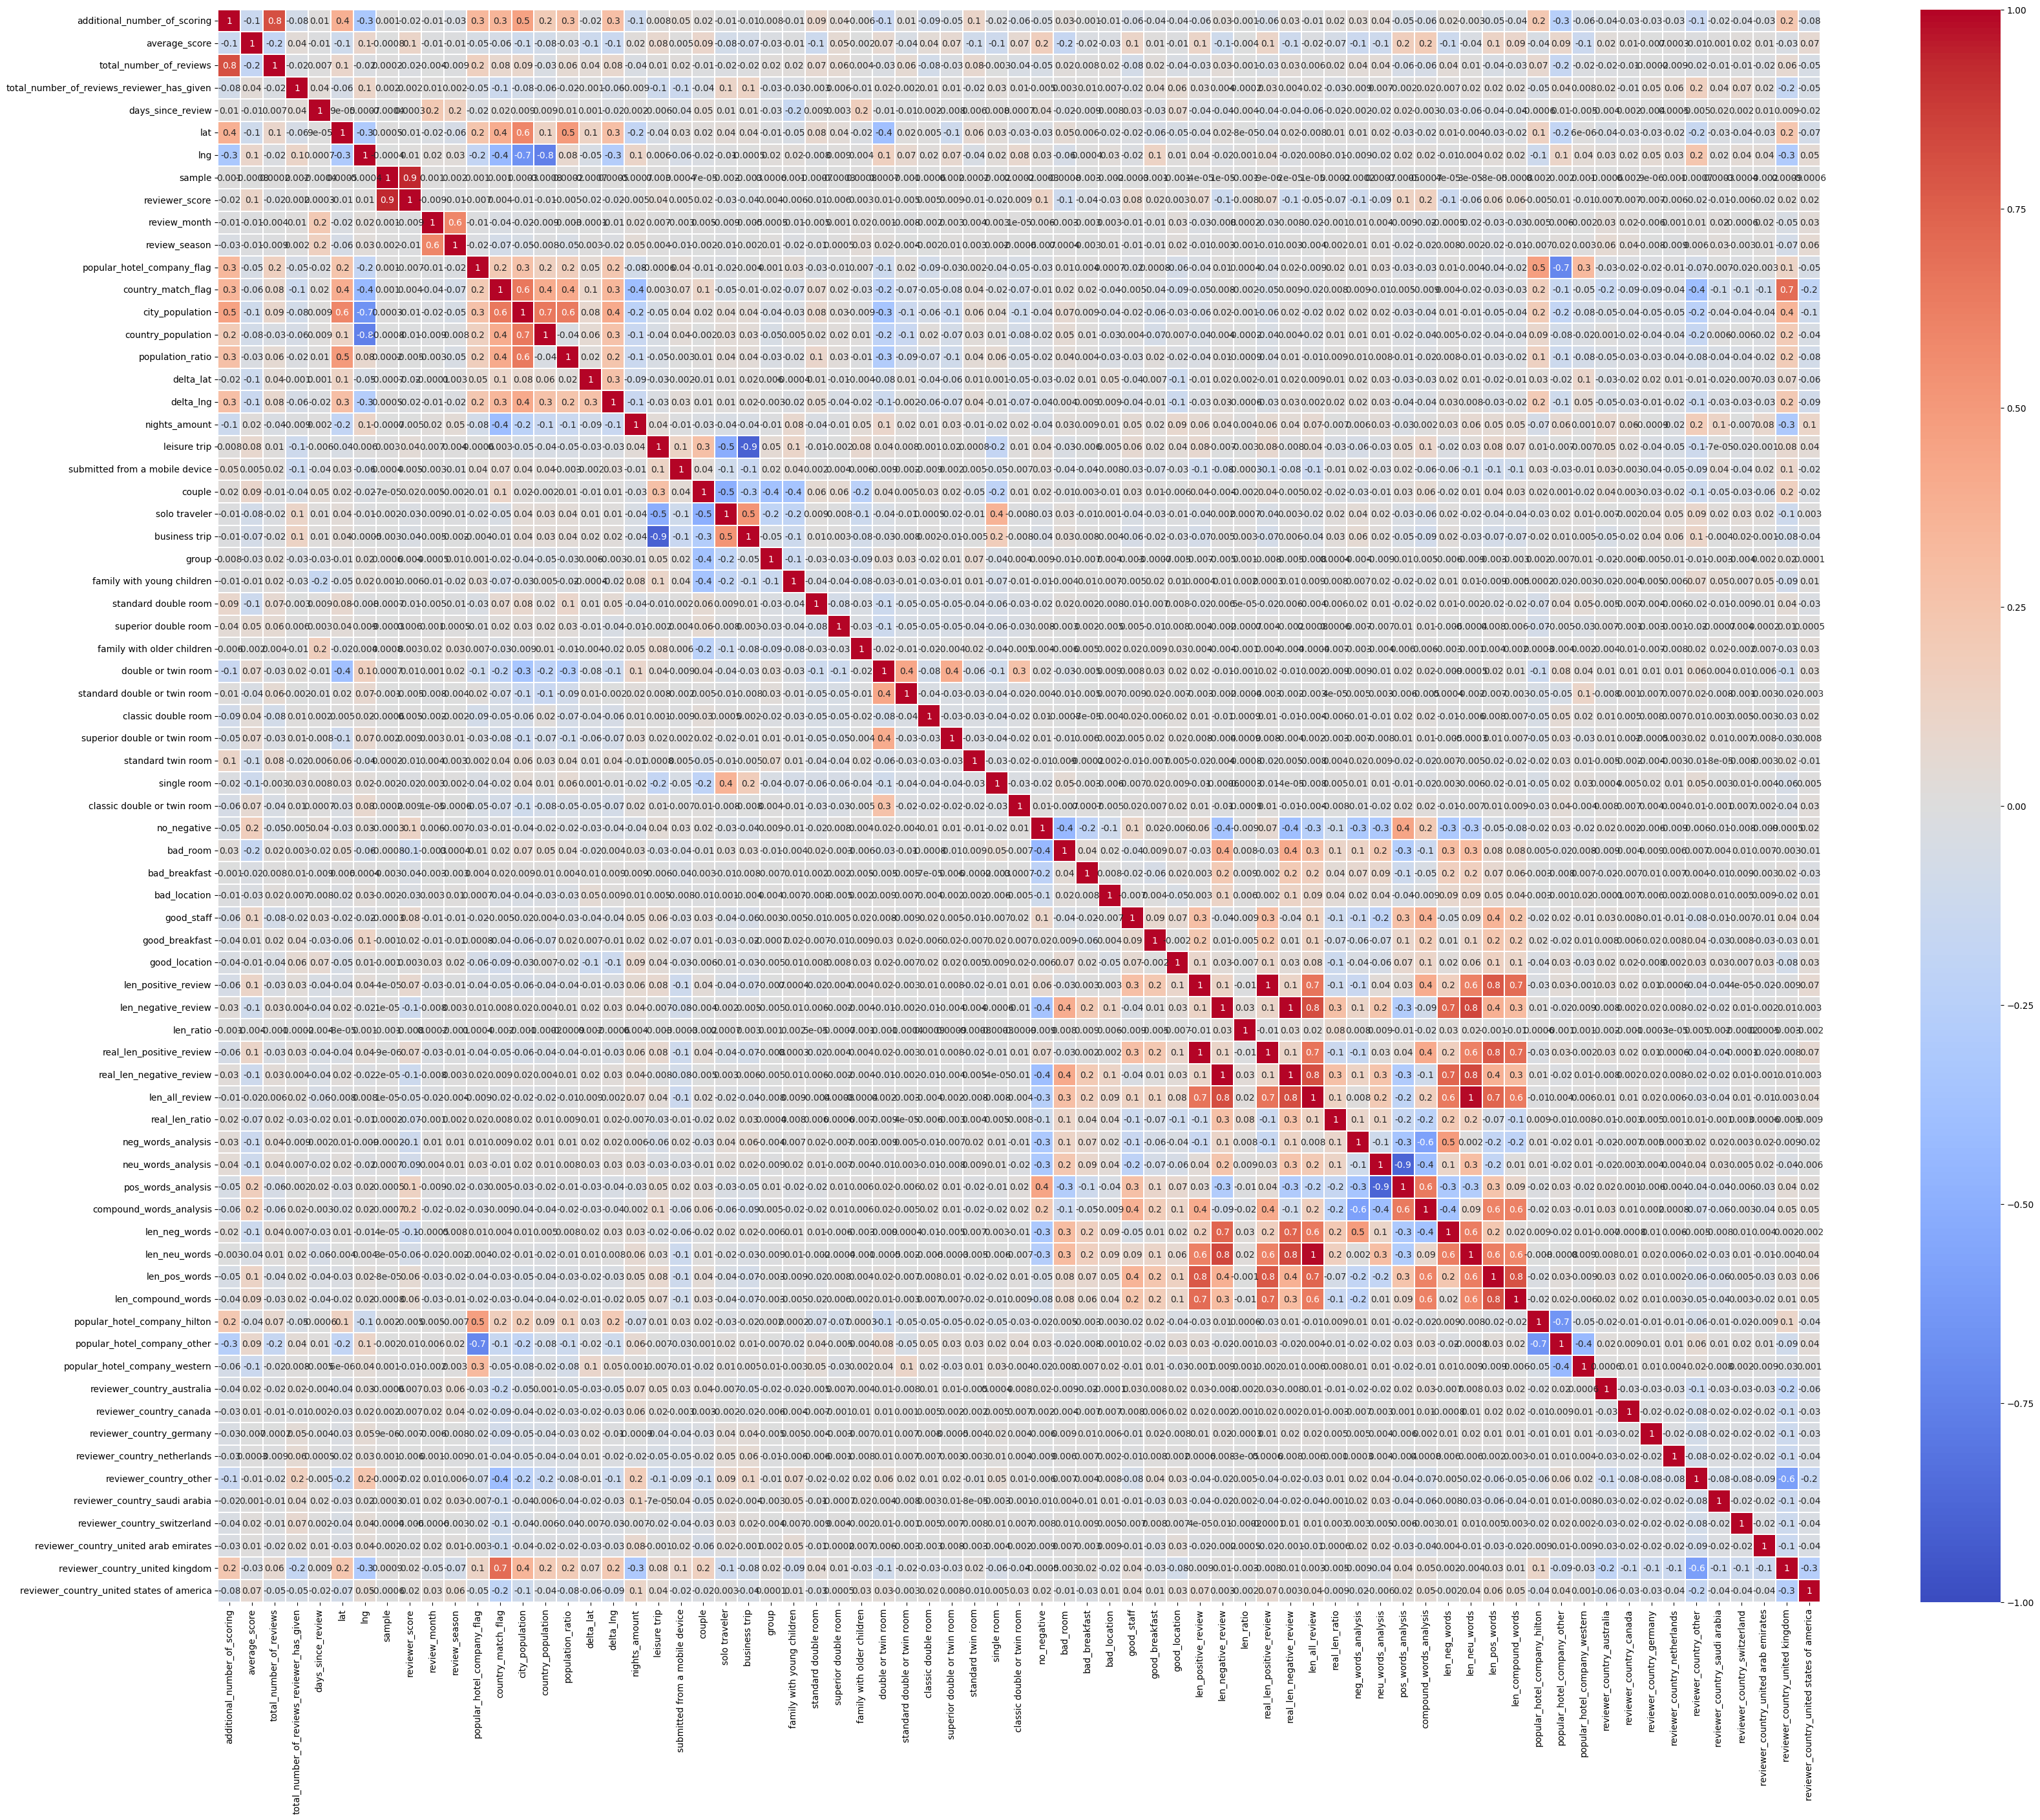

In [426]:
plt.figure(figsize=(40, 32))
_ = sns.heatmap(data.corr(), annot=True, fmt='.1g', cmap='coolwarm', linewidths=0.25, vmin=-1, vmax=1, center= 0)

### Нормализация/стандартизация признаков

У нас много бинарных признаков, но остались и те, что имеют различные большие мсштабы. Попробуем их нормализовать/стандартизовать и посмотреть на результаты работы модели.

- если признак распределён нормально, то его необходимо стандартизировать;
- если признак распределён ненормально, его необходимо нормализовать;
- если разброс значений небольшой, то можно обойтись без преобразования данных.

К сожалению нормализации стандартизация признаков не улучшили качество модели.

-------------------------

### Построение модели

Приступим к построению модели. Проверим, принесли ли плоды наши манипуляции с данными. Напомню, что нас интересует метрика MAPE. До обработки данных, этот показатель был равен **0.1413487322148218**. Хочется снизить его до уровня менее **0,1**.

In [427]:
# теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)
# воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 30% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 70), (386803, 70), (386803, 69), (270762, 69), (116041, 69))

In [428]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [429]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.852875957635663
MAPE: 0.1217805933786818


<AxesSubplot:>

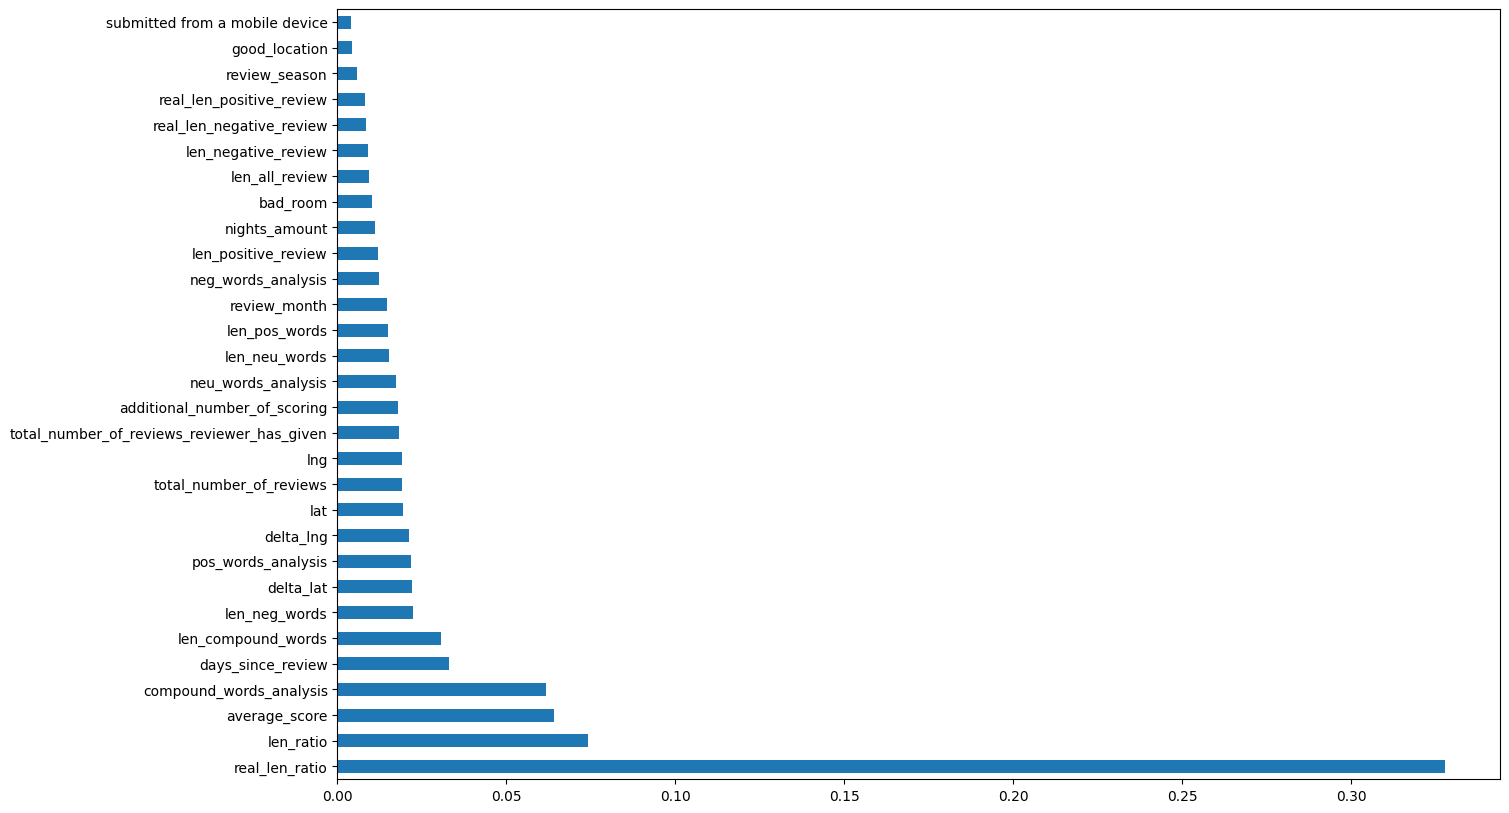

In [430]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

### Вывод
Манипуляции с данными дали результаты, показатель метрики MAPE снизился и составил примерно **0.12178**, что является нормальным уровнем. Не все преобразования положительно сказывались на результате работы модели, нормализация и стандартизация числовых признаков повышала MAPE. Конечно, хочется ещё сильнее уменьшить MAPE, можно более тщательно проверить как ведет себя модель RandomForestRegressor после удаления каждого признака (пары признаков). Но лучше улучшить знания в области ML, чтобы не гадать, а знать точно, в каких ситуациях и как именно различные модели реагируют на те или иные признаки.